In [2]:
import os
import pandas as pd
import numpy as np
import glob
import pyarrow.feather as feather
from pyarrow import csv
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
scale = preprocessing.MinMaxScaler()
pd.set_option("display.max_rows", None)


def train_test_split(df, frac=0.2):
    selected = df['flow_id'].drop_duplicates().sample(frac=frac)
    test = df[df['flow_id'].isin(selected)]
    train = df[~df['flow_id'].isin(selected)]
    return train, test
def test_case_split(df,split):
    selected = df['flow_id'].drop_duplicates().sample(frac=1)
    # print(selected.shape)
    total_data_count = selected.shape[0]
    data_per_set = int(np.floor(total_data_count/split))
    DataFrameDict = {}
    for i in range(1, split+1):
        client_name = "client_" + str(i)
        start = data_per_set * (i-1)
        end = data_per_set * i

        print(f"Adding data from {start} to {end} for client : {client_name}")
        DataFrameDict[client_name] = df[df['flow_id'].isin(selected[start:end])]
    return DataFrameDict

def label_encoding(df, columns_list):
    for col in columns_list:
        df[col] = le.fit_transform(df[col])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        with open('Label_mapping_GQUIC.txt', 'a') as data:
            data.write(col+": "+str(le_name_mapping) + "\n")
    return df


def index_reset(df):
    return pd.RangeIndex(len(df.index))


def data_scale(df):
    df.loc[:, '0': '1459'] = df.loc[:, '0': '1459'].div(255)
    # df[['length']] = scale.fit_transform(
    #     df[['length']])
    return df


def remove_protocol(df):
    df = df.loc[(df['protocol'] == 'GQUIC')]
    return df


def remove_columns(df):
    df = df.drop(['ip_proto', 'data', 'length'], axis=1)
    return df


def final_remove(df):
    df = df.drop(['ip_src', 'ip_dst', 'protocol', 'info'], axis=1)
    return df

def get_static(df):
    for col in ['A->B', 'B->A','total']:
        print("Cột {}: ".format(col))
        for num in [1000,550,500,450,100]:
            total_flow = df.shape[0]
            count = df[col][df[col] < num].count()
            remain = total_flow - count
            percent = round((count/float(df.shape[0])) * 100,2)
            print("<{} chiếm {}% ({}/{}) con lai {})".format(num,percent,count,df.shape[0],remain))

# Add label

In [ ]:
# get your working directory and target folder that contains all your files
for nhan in ['VoIP','FileTransfer','Music','Youtube']:
    path = os.path.join(os.getcwd(), '/home/onos/FL/Data_Processing/send/rawds-20/gquic/' + nhan)

    files = [os.path.join(path, i) for i in os.listdir(
        path) if os.path.isfile(os.path.join(path, i))]

    df = pd.DataFrame()

    # for every file in folder, read it and append to a empty dataframe with column filename as 'Label'
    for file in files:
        _df = pd.read_csv(file,engine='pyarrow')
        _df['Label'] = nhan
        file_name = file.split('/')
        _df['File_name'] = file_name[-1]
        df = pd.concat([df, _df], ignore_index=True)
    del _df
    df = (df.pipe(remove_columns).pipe(final_remove))
    df.index = index_reset(df)
    df.to_feather("GQUIC_feather/df_" + nhan +".feather" )
    del df


# Final

## Gop du lieu

In [ ]:
path = os.path.join(os.getcwd(),  '/home/onos/FL/Data_Processing/GQUIC_feather')
all_files = glob.glob(os.path.join(path, "*.feather"))
df_GQUIC = pd.concat((pd.read_feather(f) for f in all_files), ignore_index=True)


In [ ]:
df_GQUIC['File_name'] = df_GQUIC['File_name'].str.replace(r'.csv','',regex=True)

In [ ]:
df_sorted = df_GQUIC.sort_values(['stream_id', 'File_name'])
del df_GQUIC
df_sorted['flow_id'] = (df_sorted.groupby(['stream_id', 'File_name']).cumcount()==0).astype(int)
df_sorted['flow_id'] = df_sorted['flow_id'].cumsum()

In [ ]:
df_sorted.head()

In [ ]:
df_sorted.index = pd.RangeIndex(len(df_sorted.index))
df_sorted.to_feather('GQUIC_full.feather')
del df_sorted

## Loc flow <500 packet

In [2]:
df_sorted = pd.read_feather('GQUIC_full.feather')
df_summary = pd.read_feather('sumary.feather')
df_summary.drop('flow_id',axis=1,inplace=True)
df_sorted.drop('flow_id',axis=1,inplace=True)
df_sorted['temp'] = df_sorted['stream_id'].astype(str)+df_sorted['File_name'].astype(str)
df_summary['temp'] = df_summary['stream_id'].astype(str)+df_summary['File_name'].astype(str)

df_sorted = df_sorted[df_sorted['temp'].isin(df_summary['temp'])]
df_summary = df_summary.sort_values(['stream_id', 'File_name'])
df_summary['flow_id'] = (df_summary.groupby(['stream_id', 'File_name']).cumcount()==0).astype(int)
df_summary['flow_id'] = df_summary['flow_id'].cumsum()
df_sorted = df_sorted.sort_values(['stream_id', 'File_name'])
df_sorted['flow_id'] = (df_sorted.groupby(['stream_id', 'File_name']).cumcount()==0).astype(int)
df_sorted['flow_id'] = df_sorted['flow_id'].cumsum()
df_summary.drop('temp',axis=1,inplace=True)
df_sorted.drop('temp',axis=1,inplace=True)
df_summary_500 = df_summary[df_summary['total_pkt'] < 500]
flow_id_list = df_summary_500['flow_id'].to_list()

In [ ]:
# # Kiem tra phan loc
# value_c = df_sorted['flow_id'].value_counts()
# count_list = value_c[value_c<20].index.to_list()
# choice_list = list(set(count_list).intersection(flow_id_list))
# len(choice_list)
# choice_list[2]
# df_summary[df_summary['flow_id'] == 131075]
# df_sorted[df_sorted['flow_id'] == 131075]

In [3]:
del df_summary,df_summary_500
list_index = df_sorted.index[df_sorted['flow_id'].isin(flow_id_list)].to_list()

In [4]:
df_sorted.drop(index=list_index,axis=0,inplace=True)

In [5]:
df_sorted['flow_id'].value_counts().describe()

count    17377.0
mean        20.0
std          0.0
min         20.0
25%         20.0
50%         20.0
75%         20.0
max         20.0
Name: flow_id, dtype: float64

In [6]:
df_sorted.shape

(347540, 1468)

In [7]:
df_sorted['flow_id'].nunique()

17377

In [12]:
df_sorted.index = pd.RangeIndex(len(df_sorted.index))
df_sorted.to_feather('GQUIC_non_encoding.feather')
del df_sorted

## Chuan hoa

In [50]:
df_sorted = pd.read_feather('GQUIC_non_encoding.feather')

In [ ]:
# _,small_sample = train_test_split(df_sorted,frac=0.01)

In [ ]:
# small_sample.to_feather("data_sample.feather",)

In [51]:
(df_sorted.Label.value_counts()/20)

Youtube         5845.0
FileTransfer    4451.0
Music           4357.0
VoIP            2724.0
Name: Label, dtype: float64

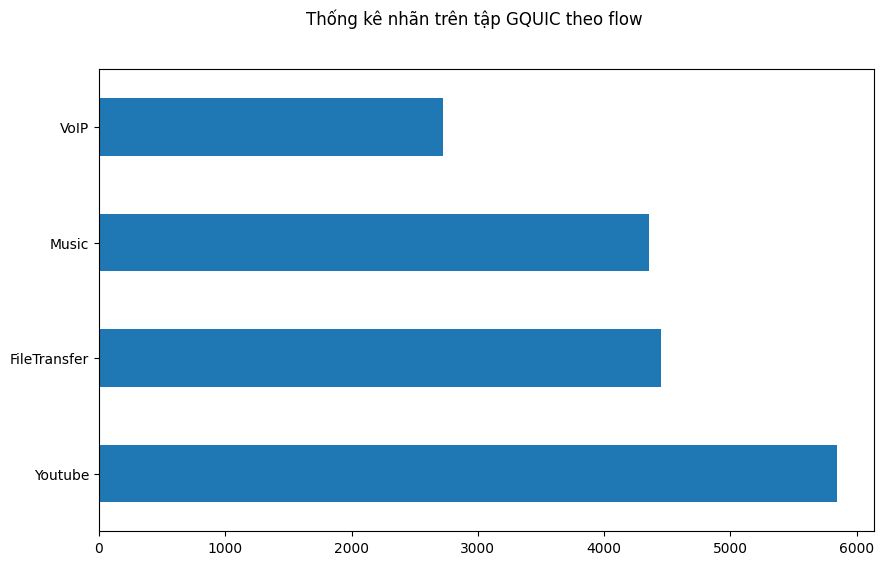

In [52]:
fig = plt.figure(figsize=(10, 6))
fig.suptitle("Thống kê nhãn trên tập GQUIC theo flow")
(df_sorted.Label.value_counts()/20).round(0).plot(kind="barh")
plt.savefig('image/GQUIC_label_flow.png')

In [53]:
df_sorted = (df_sorted.pipe(label_encoding, ['Label']))

In [54]:
df_sorted.to_feather('GQUIC_label_encoding.feather')

del df_sorted

## Chia du lieu cho test case, train, test

In [3]:
df_sorted = pd.read_feather('GQUIC_label_encoding.feather')

In [4]:
df_sorted['flow_id'].nunique()

17377

In [5]:
df_sorted['flow_id'].value_counts().describe()

count    17377.0
mean        20.0
std          0.0
min         20.0
25%         20.0
50%         20.0
75%         20.0
max         20.0
Name: flow_id, dtype: float64

In [6]:
training_data, test_case = train_test_split(df_sorted, 0.2)
print(test_case['flow_id'].nunique())
print(training_data['flow_id'].nunique())

3475
13902


In [7]:
test_case['flow_id'].value_counts().describe()

count    3475.0
mean       20.0
std         0.0
min        20.0
25%        20.0
50%        20.0
75%        20.0
max        20.0
Name: flow_id, dtype: float64

In [8]:
del df_sorted

In [9]:
test_case.columns

Index(['time_epoch', 'frame_number', 'stream_id', 'port_src', 'port_dst', '0',
       '1', '2', '3', '4',
       ...
       '1453', '1454', '1455', '1456', '1457', '1458', '1459', 'Label',
       'File_name', 'flow_id'],
      dtype='object', length=1468)

In [10]:
test_case = test_case[['time_epoch', 'frame_number', 'stream_id', 'port_src', 'port_dst', 'Label', 'File_name', 'flow_id']]
split = 5
DataFrameDict = test_case_split(test_case,split)
for df in DataFrameDict.keys():
    csv_path = "gquic_test_case/"+df + ".feather"
    DataFrameDict[df].index = index_reset(DataFrameDict[df])
    DataFrameDict[df].to_feather(csv_path)

Adding data from 0 to 695 for client : client_1
Adding data from 695 to 1390 for client : client_2
Adding data from 1390 to 2085 for client : client_3
Adding data from 2085 to 2780 for client : client_4
Adding data from 2780 to 3475 for client : client_5


In [11]:
training_data.columns

Index(['time_epoch', 'frame_number', 'stream_id', 'port_src', 'port_dst', '0',
       '1', '2', '3', '4',
       ...
       '1453', '1454', '1455', '1456', '1457', '1458', '1459', 'Label',
       'File_name', 'flow_id'],
      dtype='object', length=1468)

In [12]:
training_data.drop(['time_epoch', 'frame_number','port_src', 'port_dst' ,'File_name','stream_id'],axis=1,inplace=True)
train, test = train_test_split(training_data, frac=0.2)
del training_data
train = train.sort_values(['flow_id'])
train.index = index_reset(train)
train.to_feather('GQUIC_data.feather')
test = test.sort_values(['flow_id'])
test.index = index_reset(test)
test.to_feather("GQUIC_test.feather")

In [13]:
test.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1452', '1453', '1454', '1455', '1456', '1457', '1458', '1459', 'Label',
       'flow_id'],
      dtype='object', length=1462)

In [14]:
first_column = train.pop('flow_id')
train.insert(0, 'flow_id', first_column)

/tmp/ipykernel_24172/4194481392.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.insert(0, 'flow_id', first_column)


In [15]:
first_column = test.pop('flow_id')
test.insert(0, 'flow_id', first_column)

/tmp/ipykernel_24172/2047084605.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.insert(0, 'flow_id', first_column)


In [16]:
data_bytes = ['9','31','63','127','255','511','1023']
for each_byte in data_bytes:
    data_train = pd.concat([train.loc[:, : each_byte],train.iloc[:,-1:]],axis=1)
    data_test = pd.concat([test.loc[:, : each_byte ],test.iloc[:,-1:]],axis=1)
    each_byte = str(int(each_byte)+1)
    data_train_name = "GQUIC_data_" + each_byte +".feather"
    data_test_name = "GQUIC_test_" + each_byte +".feather"
    data_train.to_feather("/home/onos/FL/Data_Processing/GQUIC_small/Train/"+data_train_name)
    data_test.to_feather("/home/onos/FL/Data_Processing/GQUIC_small/Test/"+data_test_name)

In [ ]:
del train,test,data_train,data_test